## Installation and Requirements

In [1]:
# !pip install qc-grid
# !pip install qc-atomdb

## Import Required Libraries

In [2]:
# Import required libraries
import numpy as np
from functools import lru_cache

from grid.onedgrid import Trapezoidal
from grid.rtransform import LinearFiniteRTransform
from grid.utils import convert_cart_to_sph, generate_real_spherical_harmonics
from grid.becke import BeckeWeights
from grid import AtomGrid
from atomdb import make_promolecule

import matplotlib.pyplot as plt

## Function

The idea of this adaptive radial grid implementation involves iteratively refining a given range defined by two points, $x_i$ and $x_f$. The process begins by considering a one dimensional 2-point grid $[x_i, x_f]$ and then a 3-point grid $[x_i, x_c, x_f]$. The difference between the results obtained from these two grids is compared to a predefined threshold, $thresh$.

If the difference is greater than $thresh$, the subranges $[x_i, x_c]$ and $[x_c, x_f]$ are recursively analyzed using the same procedure. This recursive process continues until the difference falls below the given threshold.

By using this approach, the constructed points are chosen adaptively based on the error or difference within each range. Consequently, regions where the function exhibits minimal change are represented with coarser grids, while regions with significant function variations are represented with finer grids.


In [3]:
# Global list to save the calculated points, weights, and differences
global_xc_list = []
global_wc_list = []
global_diff_list = []

# Example of function definition (I randomly chose this negative exponential function)

def f(r):
    return np.exp(-r)

def adaptive_recursive_fn(xi, xf, thresh=1, onedgrid_fn=Trapezoidal, radialgrid_fn=LinearFiniteRTransform):

    print(f"\nCalculating adaptive grid for [{xi}, {xf}]")

    # 2-point grid
    onedgrid_0 = onedgrid_fn(npoints = 2)
    radial_grid_0 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_0)

    # 3-point grid
    onedgrid_1 = onedgrid_fn(npoints = 3)
    radial_grid_1 = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_1)

    # N-point grid only to see the more accurate results, not used in the algorithm. Here, N = 100
    onedgrid_N = onedgrid_fn(npoints = 100)
    radial_grid_N = radialgrid_fn(xi, xf).transform_1d_grid(onedgrid_N)

    # Calculate integration of f(x) for each case and print the output for study
    val_0 = radial_grid_0.integrate(f(radial_grid_0.points))
    val_1 = radial_grid_1.integrate(f(radial_grid_1.points))
    val_N = radial_grid_N.integrate(f(radial_grid_N.points))

    print("Initial:", val_0) # 2-points grid
    print("Incremented:", val_1) # 3-points grid
    print("Exact:", val_N) # N-points grid
    # print("Linalg:", np.dot(radial_grid_N.weights, f(radial_grid_N.points))) # Calculation with dot product to check and study

    # Obtain the center point and weight to further range subdivision. Index [1] used because it's the midpoint from [0,1,2] in 3-points grid
    xc = radial_grid_1.points[1]
    wc = radial_grid_1.weights[1]

    # Calculate the difference
    diff = abs(val_1 - val_0)

    # Save and print the value
    global_xc_list.append(xc)
    global_wc_list.append(wc)
    global_diff_list.append(diff)
    print(f"xc: {xc}, wc: {wc}")
    print(f"diff: {diff}")
    # print(global_xc_list)
    # print(global_wc_list)

    if diff < thresh:
        return diff
    else:
        # Continue recursively
        return {
            "left": adaptive_recursive_fn(xi, xc, thresh, onedgrid_fn, radialgrid_fn),
            "right": adaptive_recursive_fn(xc, xf, thresh, onedgrid_fn, radialgrid_fn)
        }

In [4]:
x_i = 0
x_f = 10

# Add initial point x_i and x_f to the global list
radial_grid_0 = LinearFiniteRTransform(x_i, x_f).transform_1d_grid(Trapezoidal(npoints=2))
global_xc_list.extend(radial_grid_0.points[:2])
global_wc_list.extend(radial_grid_0.weights[:2])

# Run the main adaptive recursive radial function
diff_log = adaptive_recursive_fn(0, 10, thresh=0.1)


Calculating adaptive grid for [0, 10]
Initial: 5.000226999648812
Incremented: 2.5338032348198336
Exact: 1.000804670299817
xc: 5.0, wc: 5.0
diff: 2.4664237648289786

Calculating adaptive grid for [0, 5.0]
Initial: 2.5168448674977135
Incremented: 1.4636349303086038
Exact: 0.9934731751290445
xc: 2.5, wc: 2.5
diff: 1.0532099371891097

Calculating adaptive grid for [0, 2.5]
Initial: 1.3526062482798735
Incremented: 1.0344341202151743
Exact: 0.9179637796282021
xc: 1.25, wc: 1.25
diff: 0.3181721280646992

Calculating adaptive grid for [0, 1.25]
Initial: 0.8040654980376188
Incremented: 0.7365711418431784
Exact: 0.7135046820475127
xc: 0.625, wc: 0.625
diff: 0.06749435619444044

Calculating adaptive grid for [1.25, 2.5]
Initial: 0.23036862217755555
Incremented: 0.21103116536685806
Exact: 0.2044225139888172
xc: 1.875, wc: 0.625
diff: 0.019337456810697484

Calculating adaptive grid for [2.5, 5.0]
Initial: 0.11102868202873033
Incremented: 0.08491152333437654
Exact: 0.07535105558756991
xc: 3.75, wc:

## Plot Results

#### 1. Plot the Grid Point

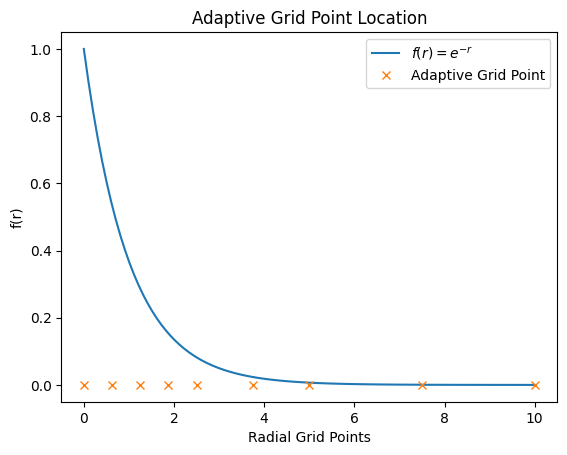

In [5]:
r = np.linspace(0, 10, 100)
plt.plot(r, f(r), label=r"$f(r) = e^{-r}$")
plt.plot(global_xc_list, np.repeat(0, len(global_xc_list)), 'x', markersize=6, label='Adaptive Grid Point')
plt.title('Adaptive Grid Point Location')
plt.xlabel('Radial Grid Points')
plt.ylabel('f(r)')
plt.legend()

The chart above used threshold = 0.1. We can observe that the grid is coarser where the function exhibits minimal change, such as in the range of 5-10. Conversely, where the function exhibits significant change, such as between 0 and 2, the grid is finer.

#### 2. Plot the difference

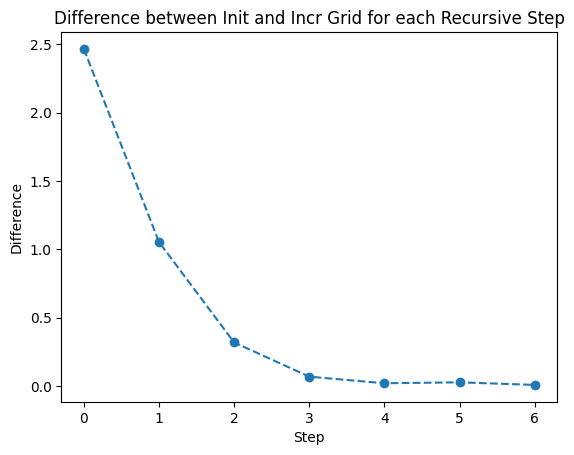

In [6]:
plt.title("Difference between Init and Incr Grid for each Recursive Step")
plt.xlabel("Step")
plt.ylabel("Difference")
plt.plot(global_diff_list, marker='o', linestyle='--', label='Difference value')

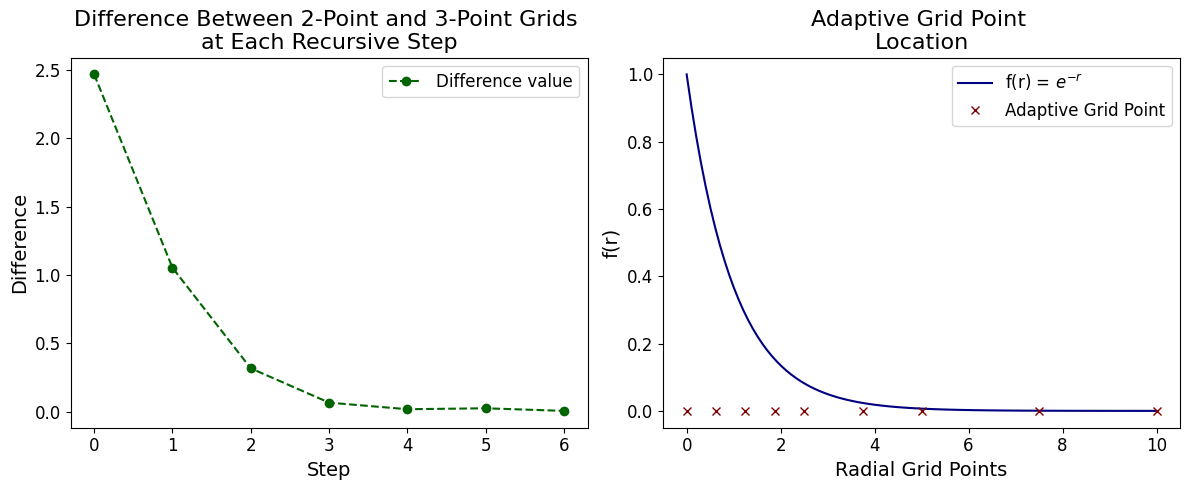

In [ ]:
# Plot both for proposal writing

import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First subplot
axes[0].plot(global_diff_list, marker='o', linestyle='--', label='Difference value', color='darkgreen')
axes[0].set_title("Difference Between 2-Point and 3-Point Grids \nat Each Recursive Step", fontsize=16)
axes[0].set_xlabel("Step", fontsize=14)
axes[0].set_ylabel("Difference", fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].legend(fontsize=12)

# Second subplot
axes[1].plot(r, f(r), label=r'f(r) = $e^{-r}$', color='navy')
axes[1].plot(global_xc_list, np.repeat(0, len(global_xc_list)), 'x', markersize=6, label='Adaptive Grid Point', color='maroon')
axes[1].set_title("Adaptive Grid Point \nLocation", fontsize=16)
axes[1].set_xlabel("Radial Grid Points", fontsize=14)
axes[1].set_ylabel("f(r)", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.savefig('adaptive_radial_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()


#### 3. Plot points and weights

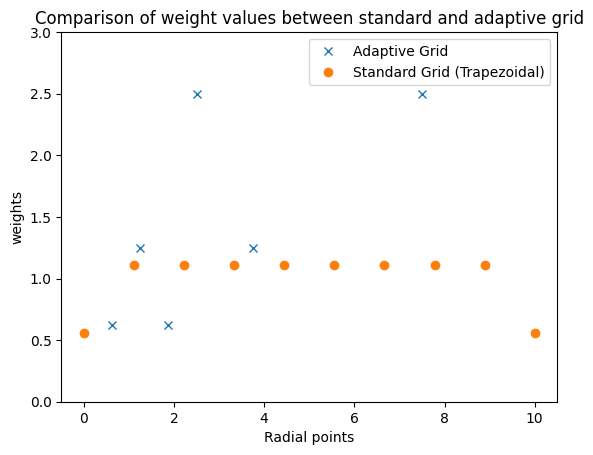

In [9]:
global_xc_list = np.array(global_xc_list)
global_wc_list = np.array(global_wc_list)

onedgrid_0 = Trapezoidal(npoints = 10)
radial_grid_0 = LinearFiniteRTransform(0, 10).transform_1d_grid(onedgrid_0)

# print(np.dot(global_wc_list, f(global_xc_list)))
# print(np.dot(radial_grid_0.weights, f(radial_grid_0.points)))

# print(global_xc_list)
# print(radial_grid_0.weights)
plt.title("Comparison of weight values between standard and adaptive grid")
plt.plot(global_xc_list, global_wc_list, 'x', label='Adaptive Grid')
plt.plot(radial_grid_0.points, radial_grid_0.weights, 'o', label='Standard Grid (Trapezoidal)')
plt.ylabel("weights")
plt.xlabel("Radial points")
plt.ylim(0, 3)
plt.legend()

Here is the current problem. Since the weight of each point is obtained in each iteration, then it is not normalized and can't be used in the integration directly. Should we integrate also "adaptively" for each subrange? should we redefined or recalculate the weights? or should we use completely different approach in creating the adaptive grid to solve this issues?